In [1]:
from __future__ import annotations

import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np

from wufam.data.prepare_data import read_kf_data
from wufam.config.trading_config import TradingConfig
from wufam.dataset import Dataset
from wufam.strategies.base_strategy import BaseStrategy
from wufam.backtest.rolling_backtest import run_rolling_backtest
from wufam.metrics.metrics import calc_sharpe

PATH = Path("../data/kf_data")
START = "1970-01-01"
END = "2024-12-31"
DATASET = Dataset.BM_6_D
FACTORS_DATASET = Dataset.FACTORS_D
WEIGHTING = "value_weighted"
FACTOR_ANNUALIZE = 252

## 1.1

In [3]:
portfolios_total_r, portfolios_xs_r, factors_df, rf = read_kf_data(
    portfolios_filename=PATH / DATASET,
    factors_filename=PATH / FACTORS_DATASET,
    start_date=START,
    end_date=END,
    weighting=WEIGHTING,
)

In [4]:
assert (
    portfolios_total_r.shape[0]
    == portfolios_xs_r.shape[0]
    == factors_df.shape[0]
    == rf.shape[0]
)

## 1.2

In [5]:
from wufam.strategies.heuristics.equally_weighted import EWStrategy
from wufam.strategies.optimized.mean_var import MeanVariance
from wufam.strategies.optimized.min_var import MinVariance

trading_config = TradingConfig(total_exposure=1)

ew_strategy = EWStrategy()

In [6]:
from wufam.estimation.mean.sample_mu_estimator import SampleMuEstimator
from wufam.estimation.covariance.sample_cov_estimator import SampleCovEstimator

mv_strategy = MeanVariance(
    mu_estimator=SampleMuEstimator(),
    cov_estimator=SampleCovEstimator(),
    trading_config=trading_config,
    window_size=None,
)

In [7]:
min_var_strategy = MinVariance(
    cov_estimator=SampleCovEstimator(),
    trading_config=trading_config,
    window_size=None,
)

In [8]:
trading_config_min_var = TradingConfig(total_exposure=1, min_exposure=0.0)

min_var_c_strategy = MinVariance(
    cov_estimator=SampleCovEstimator(),
    trading_config=trading_config_min_var,
    window_size=None,
)

In [9]:
trading_config_naive_min_var = TradingConfig(total_exposure=1, min_exposure=0.5 / 25)

min_var_naive_c_strategy = MinVariance(
    cov_estimator=SampleCovEstimator(),
    trading_config=trading_config_naive_min_var,
    window_size=None,
)

In [10]:
from wufam.estimation.covariance.shrinkage.lw_cv_cov_estimator import (
    LedoitWolfCVCovEstimator,
)

min_var_lw_strategy = MinVariance(
    cov_estimator=LedoitWolfCVCovEstimator(),
    trading_config=trading_config,
    window_size=None,
)

In [11]:
min_var_lw_cv_strategy = MinVariance(
    cov_estimator=LedoitWolfCVCovEstimator(alphas=np.linspace(0.0, 1.0, 100)),
    trading_config=trading_config,
    window_size=None,
)

In [12]:
def evaluate_strategy(
    strategy: BaseStrategy, return_weights: bool = False
) -> tuple[float, float] | tuple[float, float, pd.DataFrame]:
    bt_res = run_rolling_backtest(
        strategy=strategy,
        excess_returns=portfolios_xs_r,
        factors=factors_df,
        rf=rf,
        freq="M",
        trading_lag=1,
        return_weights=return_weights,
    )

    if return_weights:
        total_r, turnover, me_weights = bt_res
    else:
        total_r, turnover = bt_res

    sr = calc_sharpe(
        strategy_total_r=total_r,
        rf_rate=rf,
        factor_annualize=FACTOR_ANNUALIZE,
    )

    if return_weights:
        return sr, turnover.mean(), me_weights
    return sr, turnover.mean()

In [13]:
evaluate_strategy(ew_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:00<00:00, 2210.15it/s]


(0.4402388970354759, np.float64(0.01523323274185687))

In [14]:
evaluate_strategy(mv_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:00<00:00, 741.83it/s]


(0.7740316354726567, np.float64(1.2921477451893355))

In [15]:
evaluate_strategy(min_var_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:00<00:00, 880.85it/s] 


(0.9750743810605279, np.float64(0.13619695537935606))

In [16]:
evaluate_strategy(min_var_c_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:04<00:00, 144.05it/s]


(0.534876524841056, np.float64(0.027605886944878272))

In [17]:
sr, turn, w_lw = evaluate_strategy(min_var_lw_strategy, return_weights=True)

Optimizing Strategy: 100%|██████████| 659/659 [00:01<00:00, 640.37it/s]


In [18]:
# evaluate_strategy(min_var_lw_cv_strategy)

In [19]:
evaluate_strategy(min_var_naive_c_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:04<00:00, 146.55it/s]


(0.5226548451417654, np.float64(0.026025276475392864))

In [20]:
from wufam.strategies.timed.vol_managed_strategy import VolManagedStrategy
from wufam.estimation.covariance.factor.factor_cov_estimator import FactorCovEstimator
from wufam.estimation.covariance.shrinkage.pca_cov_estimator import PCACovEstimator
from wufam.estimation.covariance.shrinkage.qis import QISCovEstimator

min_var_qis_strategy = MinVariance(
    cov_estimator=QISCovEstimator(),
    trading_config=trading_config,
    window_size=365,
)

factor_cov_estimator = FactorCovEstimator(
    factor_cov_estimator=SampleCovEstimator(),
    residual_cov_estimator=PCACovEstimator(),
    factors_selection=["Mkt-RF"],
)

min_var_factor_strategy = MinVariance(
    cov_estimator=factor_cov_estimator,
    trading_config=trading_config,
    window_size=365,
)

vol_managed_trading_config = TradingConfig(min_exposure=0.0, max_exposure=2.0)

vol_managed_strategy = VolManagedStrategy(
    trading_config=vol_managed_trading_config,
    vol_window=21,
)

In [21]:
evaluate_strategy(min_var_factor_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:04<00:00, 140.72it/s]


(1.067201667960036, np.float64(0.6232884391581438))

In [22]:
evaluate_strategy(min_var_qis_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:01<00:00, 460.17it/s]


(0.9973516764669229, np.float64(0.6220852990835406))

In [23]:
evaluate_strategy(vol_managed_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:00<00:00, 944.48it/s] 


(0.5662518243684176, np.float64(0.43435775296036566))

In [24]:
sr, turnover, w = evaluate_strategy(min_var_naive_c_strategy, return_weights=True)
sr, turnover

Optimizing Strategy: 100%|██████████| 659/659 [00:04<00:00, 144.86it/s]


(0.5226548451417654, np.float64(0.026025276475392864))

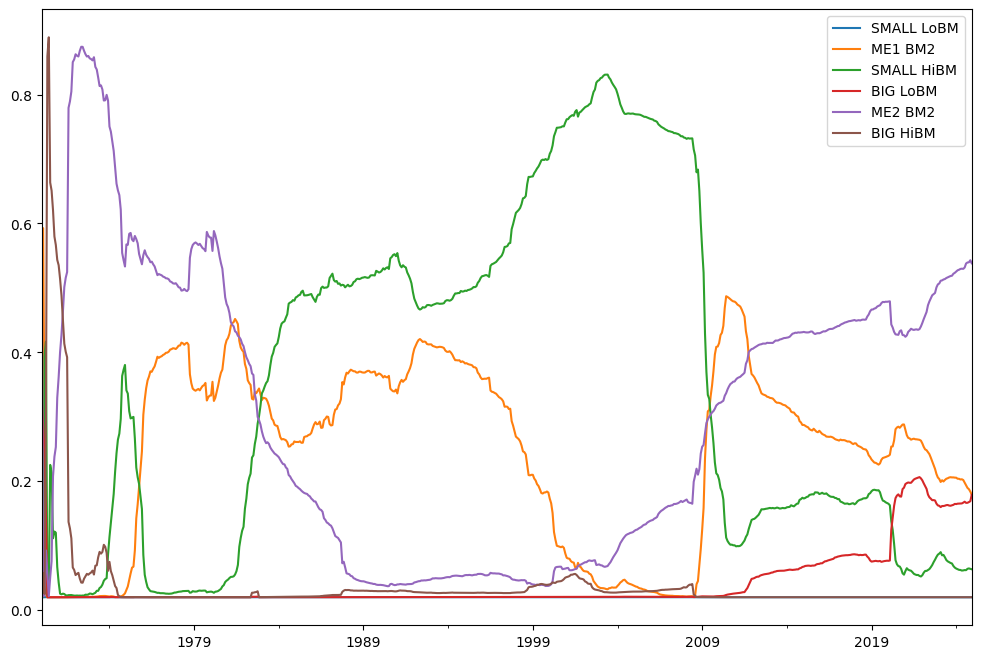

In [25]:
w.resample("ME").last().plot(figsize=(12, 8));

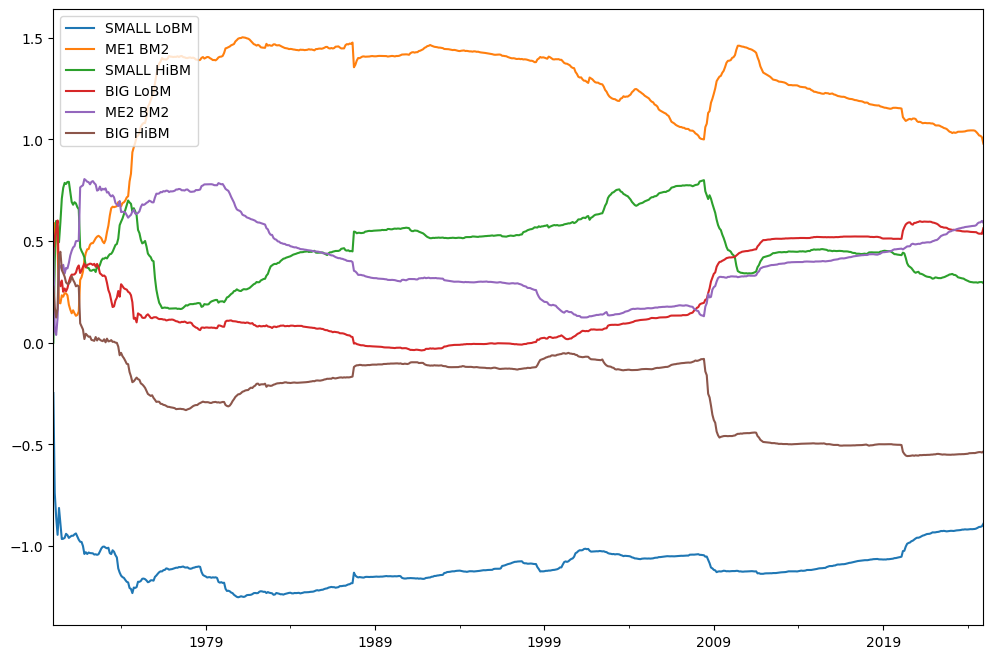

In [26]:
w_lw.resample("ME").last().plot(figsize=(12, 8));